# LSTM - Text Generation

## Concept

[Next Word Prediction Model](https://amanxai.com/2020/07/20/next-word-prediction-model)

**Long Short-Term Memory (LSTM)**

**LSTM** là một loại **Recurrent Neural Network (RNN)** đặc biệt, được thiết kế để **giải quyết vấn đề về việc học các chuỗi dài**.  

<br>

**Tại sao lại có LSTM?**

- RNN thông thường gặp vấn đề **vanishing/exploding gradient**, làm cho việc học **long-term dependencies** trở nên khó khăn.  
- LSTM ra đời với **cơ chế "cell state" và "gate"** giúp **ghi nhớ thông tin quan trọng lâu dài** và **bỏ qua thông tin không cần thiết**.  
- Vì vậy, LSTM rất hiệu quả với các bài toán **xử lý chuỗi** như:
  - Dự đoán từ tiếp theo (text generation)
  - Dịch máy (machine translation)
  - Nhận dạng giọng nói
  - Phân tích chuỗi thời gian (time series)


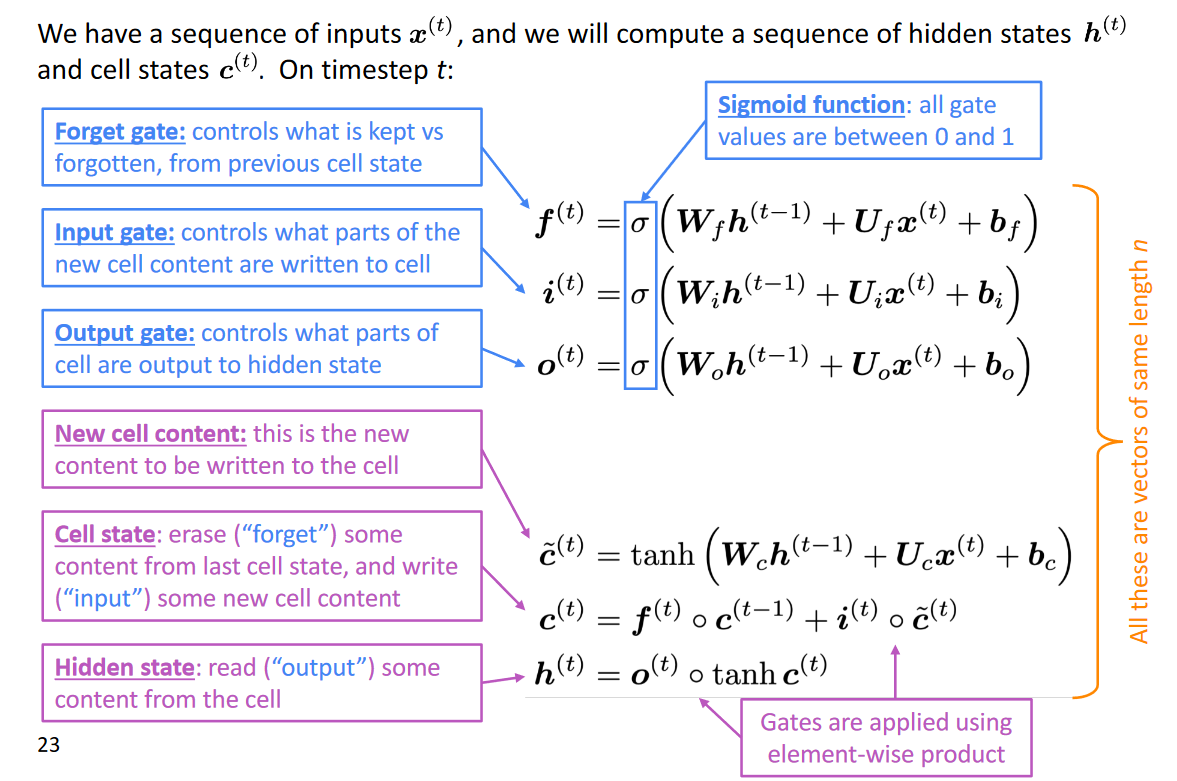

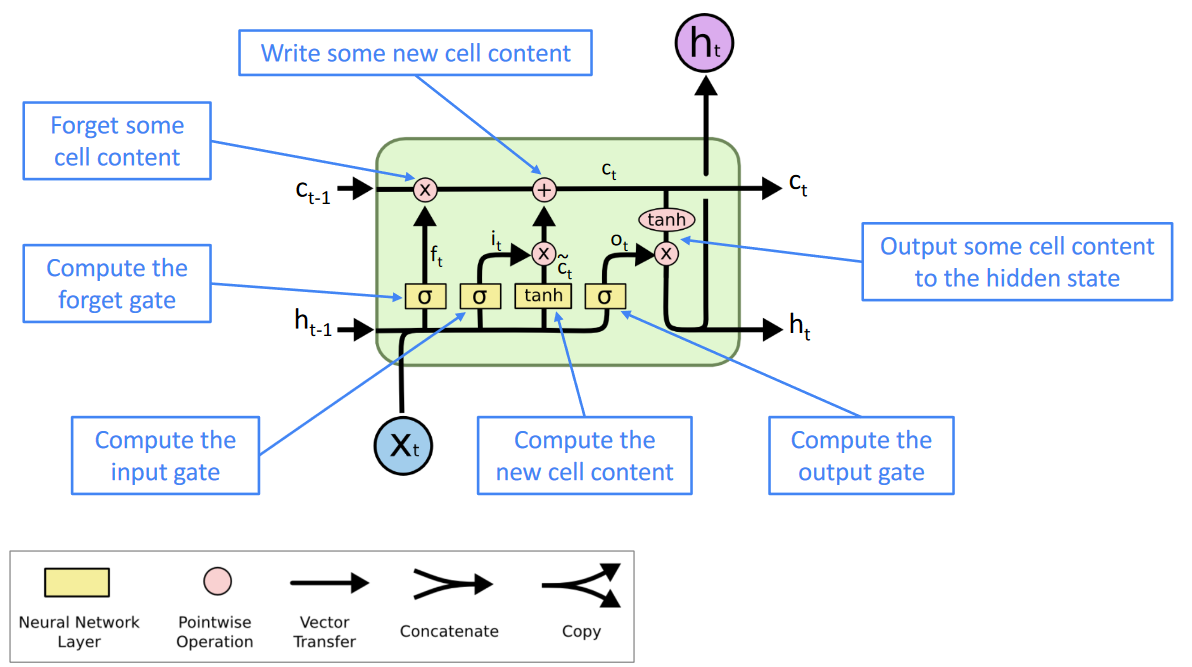

**Cơ chế hoạt động**

LSTM sử dụng ba **cổng (gate)** để kiểm soát thông tin trong cell:

- **Forget gate**: loại bỏ thông tin không cần thiết.  
- **Input gate**: cập nhật thông tin mới vào cell.  
- **Output gate**: xác định thông tin nào được xuất ra hidden state tiếp theo.  

Mỗi gate dùng **sigmoid** để đưa giá trị về 0 hoặc 1, giúp kiểm soát thông tin hiệu quả.


**Hyperparameters**

- **Số lớp (num layers)**: tăng độ sâu giúp học các quan hệ phức tạp nhưng cần nhiều dữ liệu hơn.  
- **Số đơn vị (num units)**: tăng độ rộng giúp học biểu diễn chi tiết hơn nhưng khó huấn luyện hơn.


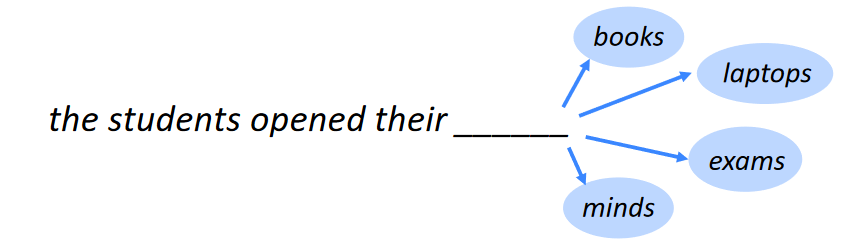

**Các mô hình phát triển từ LSTM**

LSTM là nền tảng cho nhiều mô hình tiên tiến nhằm khắc phục hạn chế về khả năng học các chuỗi dài và tốc độ huấn luyện.

- **GRU (Gated Recurrent Unit)**: Đơn giản hóa LSTM, kết hợp forget gate và input gate thành một update gate, giúp học nhanh hơn với số lượng tham số ít hơn.  

- **Bidirectional LSTM**: Chạy LSTM theo cả hai hướng (tiền và hậu), cải thiện khả năng nắm bắt ngữ cảnh trong chuỗi văn bản.  

- **Stacked / Deep LSTM**: Xếp nhiều lớp LSTM để học các biểu diễn phức tạp hơn, tăng khả năng mô hình hóa quan hệ dài hạn.  

- **Attention + LSTM**: Kết hợp cơ chế attention, cho phép LSTM tập trung vào các phần quan trọng của chuỗi đầu vào, cải thiện hiệu suất trong dịch máy, tóm tắt văn bản.  

- **Seq2Seq với LSTM**: Dùng encoder-decoder LSTM cho các bài toán sinh chuỗi, như dịch máy hoặc text generation.


## Implementation

[Kaggle - Alice's Adventures in Wonderland dataset](https://www.kaggle.com/datasets/roblexnana/alice-wonderland-dataset/data)

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("roblexnana/alice-wonderland-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'alice-wonderland-dataset' dataset.
Path to dataset files: /kaggle/input/alice-wonderland-dataset


In [11]:
import shutil

src = "/kaggle/input/alice-wonderland-dataset/"
dst = "/content/"

# copy toàn bộ folder và file
shutil.copytree(src, dst, dirs_exist_ok=True)

print("Đã copy xong dataset vào /content/")

Đã copy xong dataset vào /content/


In [9]:
"""
Mô-đun để huấn luyện mô hình LSTM hai chiều (Bidirectional LSTM)
nhằm dự đoán từ tiếp theo trong một chuỗi văn bản.
"""

import re
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# ==================== CÁC HẰNG SỐ VÀ CÀI ĐẶT ====================
SEQUENCE_LENGTH = 5
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
EPOCHS = 100
BATCH_SIZE = 64
DROPOUT_RATE = 0.4
MODEL_PATH = "lstm_alice.pth"

# Thiết lập thiết bị (GPU nếu có, không thì CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")


# ==================== CÁC HÀM TIỀN XỬ LÝ DỮ LIỆU ====================
def load_and_preprocess_data(file_path):
    """Tải và tiền xử lý dữ liệu văn bản từ một file."""
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read().lower()
    print(f"Tổng độ dài kho văn bản: {len(text)} ký tự")

    tokens = re.findall(r"[\w']+|[.!?;]", text)
    tokens = [token for token in tokens if token]
    print(f"Tổng số token: {len(tokens)}")

    word_counts = Counter(tokens)
    vocab = ["<UNK>"] + [word for word, count in word_counts.items() if count >= 3]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    vocab_size = len(vocab)
    print(f"Kích thước từ vựng (tần suất >= 3): {vocab_size}")
    print(f"Các từ phổ biến nhất: {word_counts.most_common(10)}")

    sequences, next_words = _create_sequences(tokens, word_to_idx)
    return sequences, next_words, word_to_idx, idx_to_word, vocab_size


def _create_sequences(tokens, word_to_idx):
    """Tạo chuỗi huấn luyện từ danh sách token."""
    sequences, next_words = [], []
    skipped = 0
    for i in range(len(tokens) - SEQUENCE_LENGTH):
        seq = tokens[i : i + SEQUENCE_LENGTH]
        next_word = tokens[i + SEQUENCE_LENGTH]

        unk_count = sum(1 for word in seq if word not in word_to_idx)
        if unk_count <= 1 and next_word in word_to_idx:
            seq_indices = [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in seq]
            sequences.append(seq_indices)
            next_words.append(word_to_idx[next_word])
        else:
            skipped += 1

    print(f"Số chuỗi huấn luyện: {len(sequences)} (bỏ qua {skipped} chuỗi nhiễu)")
    return sequences, next_words


# ==================== KIẾN TRÚC MÔ HÌNH LSTM ====================
# pylint: disable=R0903
class BetterLSTM(nn.Module):
    """Mô hình LSTM hai chiều (Bidirectional) với các lớp điều chuẩn."""

    def __init__(self, vocab_size, emb_dim, hid_dim, drop_rate):
        """Khởi tạo các lớp của mô hình."""
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.embedding_dropout = nn.Dropout(drop_rate)
        self.lstm = nn.LSTM(
            emb_dim,
            hid_dim,
            num_layers=2,
            batch_first=True,
            dropout=drop_rate,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(drop_rate)
        self.layer_norm = nn.LayerNorm(hid_dim * 2)
        self.fc = nn.Linear(hid_dim * 2, vocab_size)

    def forward(self, x):
        """Định nghĩa luồng dữ liệu đi qua mô hình (forward pass)."""
        embedded = self.embedding_dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        normalized = self.layer_norm(last_output)
        output = self.fc(self.dropout(normalized))
        return output


# ==================== QUY TRÌNH HUẤN LUYỆN ====================
def _prepare_dataloaders(sequences, next_words):
    """Chuẩn bị dữ liệu và tạo Dataloader."""
    x_data = torch.tensor(sequences, dtype=torch.long)
    y_data = torch.tensor(next_words, dtype=torch.long)

    train_size = int(0.7 * len(x_data))
    val_size = int(0.15 * len(x_data))
    x_train, x_val, x_test = (
        x_data[:train_size],
        x_data[train_size : train_size + val_size],
        x_data[train_size + val_size :],
    )
    y_train, y_val, y_test = (
        y_data[:train_size],
        y_data[train_size : train_size + val_size],
        y_data[train_size + val_size :],
    )

    train_loader = DataLoader(
        TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True
    )
    return train_loader, (x_val, y_val), (x_test, y_test)


def train_model(model, sequences, next_words):
    """Hàm chính để huấn luyện mô hình."""
    train_loader, (x_val, y_val), (x_test, y_test) = _prepare_dataloaders(
        sequences, next_words
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    best_val_loss, patience_counter = float("inf"), 0
    print("\nBắt đầu huấn luyện mô hình...")
    print("Epoch | Train Loss | Val Loss | Val Acc | LR")
    print("------|------------|----------|---------|--------")

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_accuracy = _validate_model(model, x_val, y_val, criterion)
        scheduler.step(val_loss)

        if (epoch + 1) % 2 == 0:
            avg_loss = total_loss / len(train_loader)
            lr = optimizer.param_groups[0]["lr"]
            print(
                f" {epoch+1:4d} |   {avg_loss:8.4f} | {val_loss:8.4f} | "
                f"{val_accuracy:7.4f} | {lr:.2e}"
            )

        if val_loss < best_val_loss:
            best_val_loss, patience_counter = val_loss, 0
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print(f"Dừng sớm tại epoch {epoch+1}")
                break

    model.load_state_dict(torch.load(MODEL_PATH))
    _, test_accuracy = _validate_model(model, x_test, y_test, criterion)
    print(f"\nĐộ chính xác cuối cùng trên tập Test: {test_accuracy:.4f}")
    return test_accuracy


def _validate_model(model, x_val, y_val, criterion):
    """Đánh giá mô hình trên tập dữ liệu validation hoặc test."""
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val.to(device))
        val_loss = criterion(val_outputs, y_val.to(device))
        _, predicted = torch.max(val_outputs, 1)
        accuracy = (predicted == y_val.to(device)).float().mean()
    return val_loss.item(), accuracy.item()


# ==================== LỚP HỖ TRỢ DỰ ĐOÁN ====================
# pylint: disable=R0903
class TextPredictor:
    """Lớp bao gói mô hình để thực hiện dự đoán một cách gọn gàng."""

    def __init__(self, model_path, word_to_idx, idx_to_word):
        self.word_to_idx = word_to_idx
        self.idx_to_word = idx_to_word
        vocab_size = len(word_to_idx)
        self.model = BetterLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT_RATE).to(
            device
        )
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def predict_top_words(self, sentence, top_k=3):
        """Dự đoán K từ tiếp theo có khả năng nhất."""
        input_indices = self._prepare_input(sentence)
        with torch.no_grad():
            input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
            output = self.model(input_tensor)
            probabilities = torch.softmax(output[0], dim=0)
            top_probs, top_indices = torch.topk(probabilities, top_k)
            return [
                (self.idx_to_word[idx.item()], prob.item())
                for prob, idx in zip(top_probs, top_indices)
            ]

    def _prepare_input(self, sentence):
        """Chuẩn bị chuỗi đầu vào từ một câu."""
        words = sentence.lower().split()
        if len(words) < SEQUENCE_LENGTH:
            padding = ["the"] * (SEQUENCE_LENGTH - len(words))
            input_words = padding + words
        else:
            input_words = words[-SEQUENCE_LENGTH:]
        return [self.word_to_idx.get(w, self.word_to_idx["<UNK>"]) for w in input_words]


# ==================== HÀM ĐIỀU PHỐI VÀ THỰC THI ====================
def run_training_pipeline():
    """Thực hiện toàn bộ quy trình huấn luyện và trả về các hiện vật."""
    print("=== DỰ ĐOÁN TỪ TIẾP THEO BẰNG LSTM ===")
    (sequences, next_words, word_to_idx, idx_to_word, vocab_size) = (
        load_and_preprocess_data("alice_in_wonderland.txt")
    )

    model = BetterLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT_RATE).to(device)
    print(f"Tổng số tham số: {sum(p.numel() for p in model.parameters()):,}")

    test_accuracy = train_model(model, sequences, next_words)

    return {
        "test_accuracy": test_accuracy,
        "word_to_idx": word_to_idx,
        "idx_to_word": idx_to_word,
    }


def show_predictions(test_accuracy, word_to_idx, idx_to_word):
    """Hiển thị kết quả dự đoán từ mô hình đã huấn luyện."""
    predictor = TextPredictor(MODEL_PATH, word_to_idx, idx_to_word)

    test_sentences = [
        "alice was beginning to get",
        "the rabbit hole went straight",
        "it was all very strange",
        "she said to herself",
        "the king and queen",
        "then she went on",
        "what a curious feeling",
        "how puzzling all these",
    ]
    print(f"\n=== KẾT QUẢ DỰ ĐOÁN (Test Acc: {test_accuracy:.3f}) ===")
    for sentence in test_sentences:
        top_predictions = predictor.predict_top_words(sentence, top_k=3)
        print(f"\nĐầu vào: '{sentence}'")
        print("Top 3 dự đoán:")
        for i, (word, prob) in enumerate(top_predictions):
            if i == 0:
                print(f"  -> '{word}' (câu đầy đủ: '{sentence} {word}')")
            else:
                print(f"  - {word}: {prob:.3f}")


def main():
    """Hàm chính để điều phối toàn bộ quy trình."""
    artifacts = run_training_pipeline()
    show_predictions(**artifacts)


if __name__ == "__main__":
    main()

Sử dụng thiết bị: cuda
=== DỰ ĐOÁN TỪ TIẾP THEO BẰNG LSTM ===
Tổng độ dài kho văn bản: 144696 ký tự
Tổng số token: 29302
Kích thước từ vựng (tần suất >= 3): 1086
Các từ phổ biến nhất: [('the', 1653), ('.', 999), ('and', 873), ('to', 729), ('a', 637), ('it', 592), ('she', 549), ('i', 524), ('of', 517), ('said', 460)]
Số chuỗi huấn luyện: 26012 (bỏ qua 3285 chuỗi nhiễu)
Tổng số tham số: 3,064,638

Bắt đầu huấn luyện mô hình...
Epoch | Train Loss | Val Loss | Val Acc | LR
------|------------|----------|---------|--------
    2 |     5.3231 |   5.4065 |  0.1356 | 1.00e-02
    4 |     5.0717 |   5.3293 |  0.1297 | 1.00e-02
    6 |     4.9660 |   5.3286 |  0.1215 | 1.00e-02
    8 |     4.8960 |   5.2868 |  0.1307 | 1.00e-02
   10 |     4.8510 |   5.3196 |  0.1213 | 1.00e-02
   12 |     4.8140 |   5.2809 |  0.1453 | 1.00e-02
   14 |     4.7765 |   5.3212 |  0.1254 | 1.00e-02
   16 |     4.7650 |   5.2833 |  0.1323 | 5.00e-03
   18 |     4.6052 |   5.2236 |  0.1505 | 5.00e-03
   20 |     4.548

**Nhận xét mô hình LSTM**

Mô hình Bidirectional LSTM hai tầng đạt độ chính xác ~16%, cho thấy khả năng học được ngữ cảnh ngắn hạn nhưng còn yếu trong việc xử lý phụ thuộc dài và biểu diễn ngữ nghĩa sâu.  
Hiện tại mô hình có dấu hiệu **underfitting**, có thể do số epoch thấp, embedding chưa tối ưu hoặc dữ liệu chưa được cân bằng.  
**Đề xuất cải thiện:**  
- Sử dụng pretrained embeddings (GloVe, FastText, hoặc Word2Vec) để tăng khả năng hiểu ngữ nghĩa.  
- Tăng kích thước hidden layer và sequence length để mô hình học tốt hơn các phụ thuộc ngữ cảnh.  
- Áp dụng regularization (dropout, early stopping) và tuning hyperparameter.  
- Thử nghiệm các mô hình nâng cao hơn như **Transformer, BERT hoặc GRU** để so sánh hiệu suất.
